# TM10007 Assignment template

In [296]:
# Run this to use from colab environment
!git clone https://github.com/Doesjka/TM10007_ML_g9.git

fatal: destination path 'TM10007_ML_g9' already exists and is not an empty directory.


## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [297]:
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import decomposition
import seaborn
import matplotlib.pyplot as plt

data = pd.read_csv('/content/TM10007_ML_g9/worclipo/Lipo_radiomicFeatures.csv', index_col=0)
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')


The number of samples: 115
The number of columns: 494


## Splitting data in train and test set


In [298]:
# X = data.reset_index(drop=True)
y = data['label']
X = data.drop('label', axis=1)
# print(X)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# print(X_train)



## Handling missing data 
### Throwing out features
All features that exist of at least 50% zeros are deleted from the data. 


In [299]:
zeros = (X_train == 0).sum()
threshold = 0.5 * len(y_train)
print('Threshold = ', threshold)
feature_del = zeros[zeros > threshold]

X_train = X_train.drop(columns=feature_del.index)
print(f'{len(data.columns)-len(X_train.columns)} features were deleted')

Threshold =  43.0
25 features were deleted


In [300]:
more_zeros = (X_train == 0).sum()
columns_zeros = more_zeros[more_zeros > 0].index
print(f'Of the remaining features, {len(columns_zeros)} features have at least one zero')
print(f'There is a total of {more_zeros.sum()} zeros left in the data')


Of the remaining features, 10 features have at least one zero
There is a total of 44 zeros left in the data


## Calculate number of missing values per sample

In [301]:
zeros_r = (X_train == 0).sum(axis=1)
threshold = 0.005 * X_train.size / len(y_train)
print('Threshold = ', threshold)
feature_del = zeros_r[zeros_r > threshold]
print(feature_del)

Threshold =  2.345
ID
Lipo-090_0    5
Lipo-095_0    3
Lipo-076_0    3
Lipo-003_0    3
dtype: int64


In [302]:
from scipy.stats import shapiro

aantal_normaal = 0

for column in X_train.columns:
    result = shapiro(X_train[column])
    # print(result.pvalue)
    normaal = result.pvalue > 0.05
    aantal_normaal += normaal
    
print(aantal_normaal)



74


/usr/local/lib/python3.9/dist-packages/scipy/stats/_morestats.py:1813: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


### Filling remaining zeros
All remaining zeros are replaced by the mean of that feature. 

In [303]:
X_train_mean = X_train
X_train_median = X_train

for column in columns_zeros[:]:
    print('Kolom: ', column)
    column_mean = X_train.loc[X_train[column]!=0, column].mean()
    column_median = X_train.loc[X_train[column]!=0, column].median()
    print('mean = ', column_mean)
    print('median = ', column_median)

    verschil2_percolumn = column_mean - column_median
    print('Verschil tussen mean en median = ',verschil2_percolumn)

    # result = shapiro(X_train[column])
    # result.pvalue
    print('p-waarde normaalverdeling = ', shapiro(X_train.loc[X_train[column]!=0, column]).pvalue)

    X_train_mean[column].replace(0, column_mean)
    X_train_median[column].replace(0, column_median)

    print(' ')

verschil = abs(X_train_mean - X_train_median)
print('Totaal verschil = ', verschil.sum().sum())

# X_train.head()
# pd.set_option('display.max_rows', None)
# print(X_train[columns_zeros[0]])
# pd.set_option('display.max_rows', 10)


Kolom:  PREDICT_original_sf_area_min_2.5D
mean =  456.8698899846219
median =  200.39520811289555
Verschil tussen mean en median =  256.4746818717264
p-waarde normaalverdeling =  3.05788068477586e-11
 
Kolom:  PREDICT_original_tf_LBP_quartile_range_R8_P24
mean =  9.301204819277109
median =  11.0
Verschil tussen mean en median =  -1.6987951807228914
p-waarde normaalverdeling =  1.931198130478151e-05
 
Kolom:  PREDICT_original_vf_Frangi_full_quartile_range_SR(1.0, 10.0)_SS2.0
mean =  2.766293780856362e-07
median =  4.602205232532876e-10
Verschil tussen mean en median =  2.7616915756238295e-07
p-waarde normaalverdeling =  9.707482768662333e-20
 
Kolom:  PREDICT_original_vf_Frangi_edge_quartile_range_SR(1.0, 10.0)_SS2.0
mean =  2.766293780856362e-07
median =  4.602205232532876e-10
Verschil tussen mean en median =  2.7616915756238295e-07
p-waarde normaalverdeling =  9.707482768662333e-20
 
Kolom:  PREDICT_original_vf_Frangi_inner_quartile_range_SR(1.0, 10.0)_SS2.0
mean =  8.705055316112096e-

## Scaling

In [304]:
scaler = preprocessing.StandardScaler().fit(X_train_median)
X_train_scaled = scaler.transform(X_train_median)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_median.columns)

# scaler = preprocessing.RobustScaler().fit(X_train_median)
# X_train_scaled = scaler.transform(X_train_median)
# X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_median.columns)

# scaler = preprocessing.MinMaxScaler().fit(X_train_median)
# X_train_scaled = scaler.transform(X_train_median)
# X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_median.columns)

## PCA
Eerst willen we bepalen welk type PCA het best werkt. Hiervoor kijken we welke het minste aantal principal components nodig heeft om 90% van de variance explained te halen.

linear  [0.21867551 0.16786209 0.09417798 0.05493918 0.0431145 ]
poly  2   [0.21535489 0.16550997 0.09385792 0.05409284 0.04301359]
poly  3   [0.21216991 0.16322921 0.09348806 0.05331683 0.04292886]
poly  4   [0.20911816 0.16101961 0.09306836 0.05262182 0.04284957]
rbf  [0.20801143 0.1600155  0.09115295 0.05331986 0.04235339]


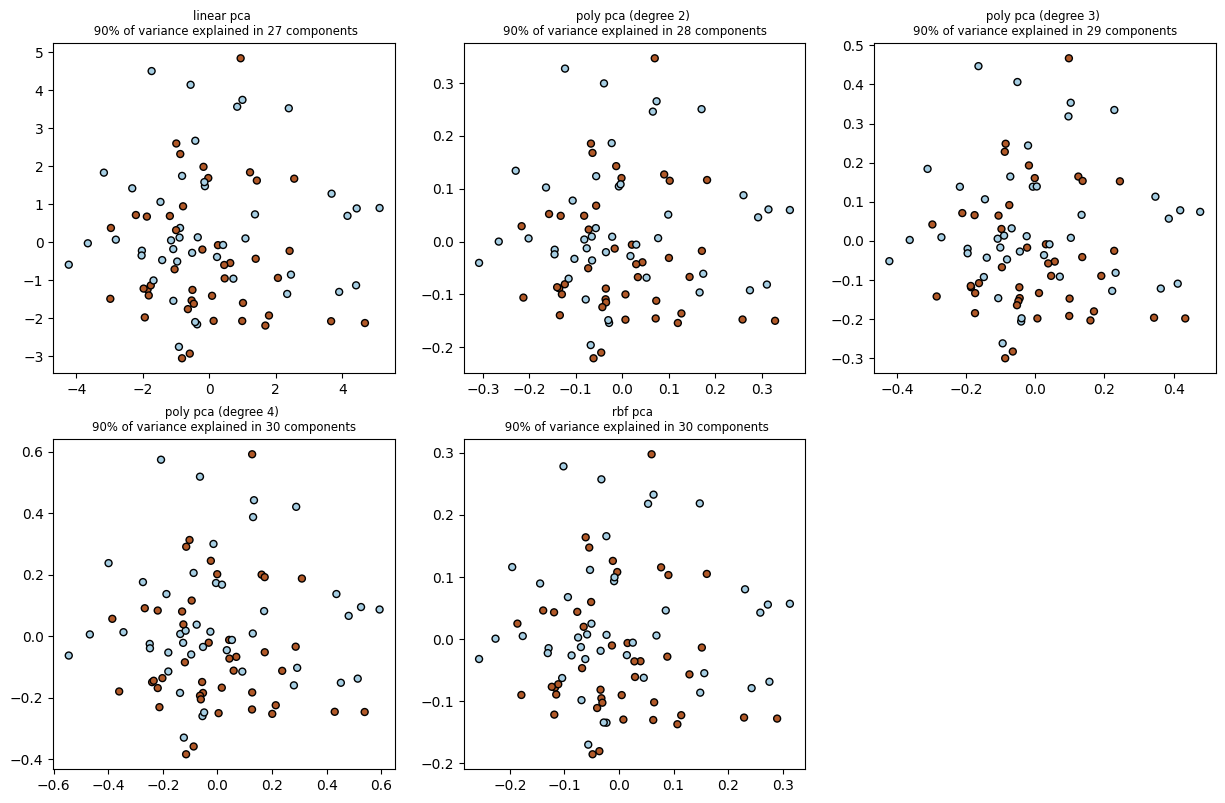

In [305]:
kernels = ['linear', 'poly', 'rbf']#, 'sigmoid', 'cosine']#, 'precomputed'] 
degrees = [2, 3, 4]

# Figuur initiëren
fig = plt.figure(figsize=(15,10*len(kernels)))
# Categorieën omzetten naar nullen en enen zodat de kleuren makkelijk in een keer gedaan kunnen worden.
y_train.values[y_train.values == 'lipoma'] = 0
y_train.values[y_train.values == 'liposarcoma'] = 1

num=0 
for kernel in kernels:
    if kernel == 'poly':
        for degree in degrees:
            pca = decomposition.KernelPCA(kernel=kernel,degree=degree)
            pca.fit(X_train_scaled_df)
            X_pca = pca.transform(X_train_scaled_df)
            ax = fig.add_subplot(6, 3, num + 1)
            ax.scatter(X_pca[:, 0], X_pca[:, 1], marker='o', c=y_train,
               s=25, edgecolor='k', cmap=plt.cm.Paired)
            
            # print(kernel + " ", str(degree), " ", pca.eigenvalues_[0:5])
            explained_variance_ratios = pca.eigenvalues_ / pca.eigenvalues_.sum()
            print(kernel + " ", str(degree), " ", explained_variance_ratios[0:5])
            
            total_ratio = 0
            i=0
            while total_ratio < 0.9:
                total_ratio += explained_variance_ratios[i]
                i+=1

            ax.set_title(kernel + " pca (degree " + str(degree) + ") \n" +
                        #  "r5 = " + str(round(explained_variance_ratios[0:4].sum(),3))+ " "  +
                        #  "r10 = " + str(round(explained_variance_ratios[0:9].sum(),3))+ " "  +
                    "90% of variance explained in " + str(i) + " components",
             fontsize='small')
            num+=1
    else:
        pca = decomposition.KernelPCA(kernel=kernel)
        pca.fit(X_train_scaled_df)
        X_pca = pca.transform(X_train_scaled_df)
        ax = fig.add_subplot(6, 3, num + 1)
        ax.scatter(X_pca[:, 0], X_pca[:, 1], marker='o', c=y_train,
               s=25, edgecolor='k', cmap=plt.cm.Paired)
        
        # print(kernel, " ", pca.eigenvalues_[0:5])
        explained_variance_ratios = pca.eigenvalues_ / pca.eigenvalues_.sum()
        print(kernel + " ", explained_variance_ratios[0:5])

        i=0
        total_ratio = 0
        while total_ratio < 0.9:
            total_ratio += explained_variance_ratios[i]
            i+=1

        ax.set_title(kernel + " pca \n " + 
            	    # "r5 = " + str(round(explained_variance_ratios[0:4].sum(),3))+ " "  +
                    # "r10 = " + str(round(explained_variance_ratios[0:9].sum(),3))+ " "  +
                    "90% of variance explained in " + str(i) + " components",
             fontsize='small')

        num+=1


We kiezen voor linear pca, gezien daar het minste componenten nodig zijn om de 90% te halen.

Nu moeten de PC's nog in een dataframe gezet worden zodat we de volgende stappen hiermee uit kunnen voeren.

In [311]:
pca = decomposition.PCA()
pca.fit(X_train_scaled_df)
X_pca = pca.transform(X_train_scaled_df)
print("gewoon pca ", pca.explained_variance_ratio_[0:4])

component=0
total_ratio = 0
while total_ratio < 0.9:
    total_ratio += pca.explained_variance_ratio_[component]
    component+=1

X_pca = X_pca[:, 0:component]


gewoon pca  [0.21867551 0.16786209 0.09417798 0.05493918]
0.9023456402494484
27
[[ 1.30504128e-01 -2.06573686e+00  1.95226548e+00 ... -2.12246892e-01
   1.77693932e-01 -2.72582030e-01]
 [ 1.01406244e+00 -1.59433222e+00 -8.36940916e-01 ... -5.34883742e-02
   3.51787741e-01 -2.33120421e-01]
 [-1.93940302e+00 -1.97477364e+00 -1.51492791e+00 ... -3.01463930e-01
  -9.61471940e-02 -4.33745028e-02]
 ...
 [ 4.41585885e+00 -1.13135290e+00 -5.28177838e-01 ...  1.99992233e-03
  -9.85178457e-02  2.84850153e-01]
 [-5.16057787e-01 -2.77418711e-01 -1.67085214e+00 ...  3.07725244e-02
  -1.45062251e-01 -1.17295876e-01]
 [-1.47671057e-01  1.58244049e+00 -2.15269239e+00 ...  5.39693797e-01
  -3.70131617e-01  2.06827058e-01]]
2322
